In [1]:
# Task 2: Bayesian Change Point Analysis
print("Starting change point analysis...")
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("PyMC version:", pm.__version__)
print("All libraries loaded successfully!")

Starting change point analysis...


ModuleNotFoundError: No module named 'pymc'

In [2]:
# Install PyMC directly in the notebook
import sys
!{sys.executable} -m pip install pymc arviz

  Using cached pymc-5.27.1-py3-none-any.whl.metadata (17 kB)
  Using cached arviz-0.23.4-py3-none-any.whl.metadata (9.1 kB)
  Using cached etuples-0.3.10-py3-none-any.whl.metadata (4.8 kB)
  Using cached logical_unification-0.4.7-py3-none-any.whl.metadata (15 kB)
  Using cached minikanren-1.0.5-py3-none-any.whl.metadata (7.6 kB)
  Using cached cons-0.4.7-py3-none-any.whl.metadata (3.8 kB)
  Using cached h5netcdf-1.8.1-py3-none-any.whl.metadata (15 kB)
  Using cached xarray_einstats-0.9.1-py3-none-any.whl.metadata (5.9 kB)
Using cached pymc-5.27.1-py3-none-any.whl (552 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ----

In [3]:
# Now try importing again
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("PyMC version:", pm.__version__)
print("Installation successful!")

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


PyMC version: 5.27.1
Installation successful!


In [4]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Now load the data
df = pd.read_csv('../data/brent_prices_cleaned.csv', parse_dates=['Date'])
print("Data loaded successfully!")
print("Shape:", df.shape)
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("\nFirst 5 rows:")
print(df.head())

Data loaded successfully!
Shape: (9011, 2)
Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00

First 5 rows:
        Date  Price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63


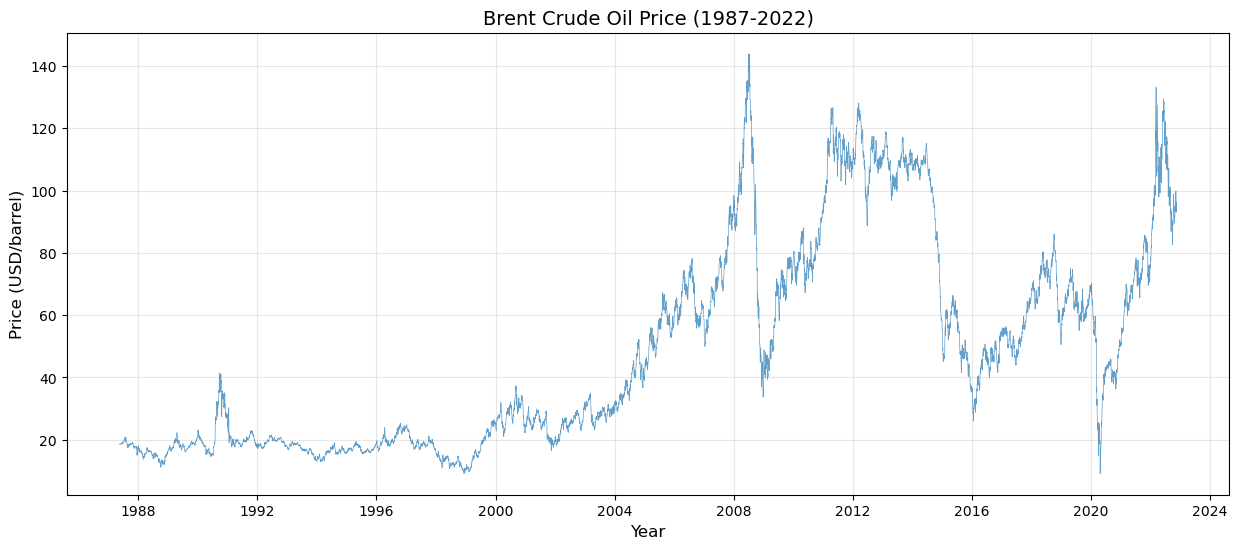

In [5]:
# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['Price'], linewidth=0.5, alpha=0.7)
plt.title('Brent Crude Oil Price (1987-2022)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD/barrel)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

Recent data (2017-2022) shape: (1495, 2)
Number of days: 1495


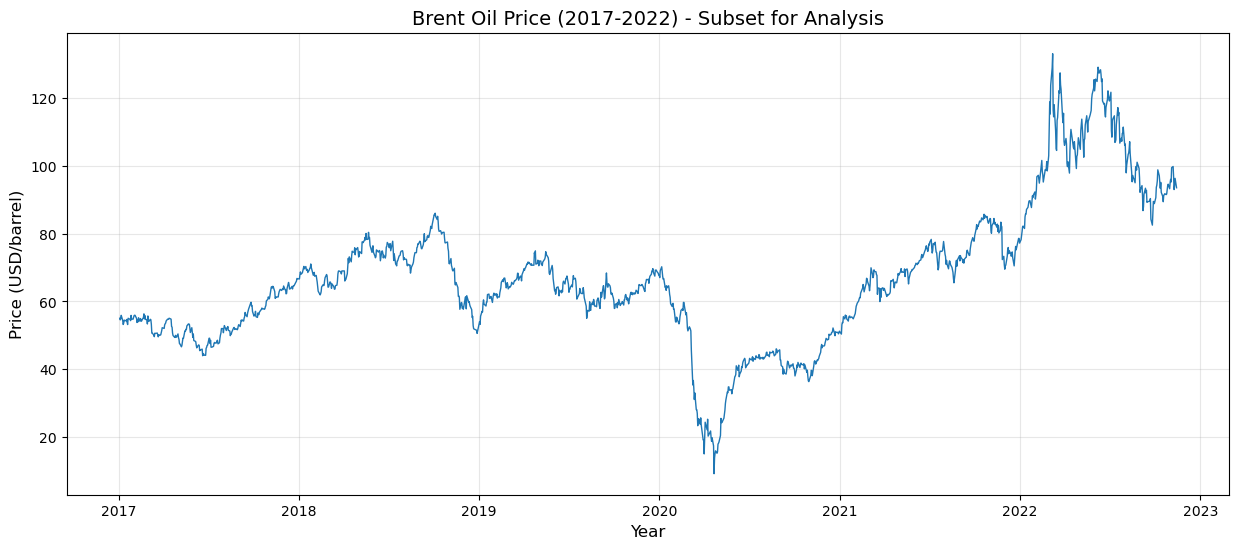

In [6]:
# Let's take a subset of recent data (last 5 years) for initial testing
recent_df = df[df['Date'] >= '2017-01-01'].copy()
print("Recent data (2017-2022) shape:", recent_df.shape)
print("Number of days:", len(recent_df))

# Plot the subset
plt.figure(figsize=(15, 6))
plt.plot(recent_df['Date'], recent_df['Price'], linewidth=1)
plt.title('Brent Oil Price (2017-2022) - Subset for Analysis', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD/barrel)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Prepare data for PyMC model
prices = recent_df['Price'].values
dates = recent_df['Date'].values
n_days = len(prices)

print(f"Prepared {n_days} data points for modeling")
print(f"Price range: ${prices.min():.2f} to ${prices.max():.2f}")
print(f"Average price: ${prices.mean():.2f}")

Prepared 1495 data points for modeling
Price range: $9.12 to $133.18
Average price: $66.82


In [8]:
print("Building Bayesian Change Point Model...")
print(f"Model will analyze {n_days} days of price data")

Building Bayesian Change Point Model...
Model will analyze 1495 days of price data


In [9]:
with pm.Model() as change_point_model:
    
    print("Step 1: Defining priors...")
    
    # 1. Define the change point (tau) - discrete uniform prior
    # tau can be any day between 0 and n_days-1
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_days-1)
    
    # 2. Define means before and after change point
    mu1 = pm.Normal("mu1", mu=prices.mean(), sigma=50)
    mu2 = pm.Normal("mu2", mu=prices.mean(), sigma=50)
    
    # 3. Define standard deviation
    sigma = pm.HalfNormal("sigma", sigma=30)
    
    print("Step 2: Creating switch function...")
    
    # 4. Create a switch function: use mu1 before tau, mu2 after tau
    # pm.math.switch(condition, value_if_true, value_if_false)
    mean = pm.math.switch(tau > np.arange(n_days), mu1, mu2)
    
    print("Step 3: Defining likelihood...")
    
    # 5. Likelihood - observed data
    likelihood = pm.Normal("likelihood", mu=mean, sigma=sigma, observed=prices)
    
    print("Model defined successfully!")
    print("\nModel variables:", list(change_point_model.named_vars.keys()))

Step 1: Defining priors...
Step 2: Creating switch function...
Step 3: Defining likelihood...
Model defined successfully!

Model variables: ['tau', 'mu1', 'mu2', 'sigma', 'likelihood']


In [ ]:
print("Starting MCMC sampling...")
print("This may take 1-2 minutes...")

with change_point_model:
    # Sample from posterior
    trace = pm.sample(
        draws=1000,      # Number of samples
        tune=500,        # Burn-in samples
        chains=2,        # Number of chains
        random_seed=42,  # For reproducibility
        progressbar=True # Show progress bar
    )
    
print("\nSampling completed!")
print(f"Number of samples: {trace.posterior.sizes['draw'] * trace.posterior.sizes['chain']}")

In [ ]:
print("Starting MCMC sampling...")
print("This may take 1-2 minutes...")

with change_point_model:
    # Sample from posterior
    trace = pm.sample(
        draws=1000,      # Number of samples
        tune=500,        # Burn-in samples
        chains=2,        # Number of chains
        random_seed=42,  # For reproducibility
        progressbar=True # Show progress bar
    )
    
print("\nSampling completed!")
print(f"Number of samples: {trace.posterior.sizes['draw'] * trace.posterior.sizes['chain']}")

In [13]:
print("Testing if model is still accessible...")
try:
    print("Model variables:", list(change_point_model.named_vars.keys()))
    print("Model seems OK")
except:
    print("Need to redefine model")

Testing if model is still accessible...
Model variables: ['tau', 'mu1', 'mu2', 'sigma', 'likelihood']
Model seems OK


Test data: 729 days (2020-2022)
Price range: $9.12 to $133.18


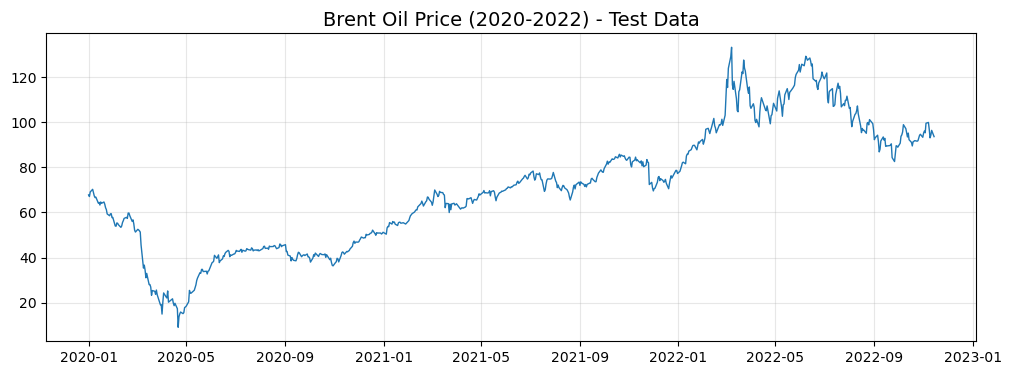

In [14]:
# Let's try with even smaller data for testing
test_df = df[df['Date'] >= '2020-01-01'].copy()
test_prices = test_df['Price'].values
test_n = len(test_prices)

print(f"Test data: {test_n} days (2020-2022)")
print(f"Price range: ${test_prices.min():.2f} to ${test_prices.max():.2f}")

# Quick plot
plt.figure(figsize=(12, 4))
plt.plot(test_df['Date'], test_prices, linewidth=1)
plt.title('Brent Oil Price (2020-2022) - Test Data', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# Build simpler model
with pm.Model() as test_model:
    
    # Priors
    tau = pm.DiscreteUniform("tau", lower=0, upper=test_n-1)
    mu1 = pm.Normal("mu1", mu=test_prices.mean(), sigma=30)
    mu2 = pm.Normal("mu2", mu=test_prices.mean(), sigma=30)
    sigma = pm.HalfNormal("sigma", sigma=20)
    
    # Switch
    mean = pm.math.switch(tau > np.arange(test_n), mu1, mu2)
    
    # Likelihood
    likelihood = pm.Normal("likelihood", mu=mean, sigma=sigma, observed=test_prices)
    
print("Test model built successfully!")

Test model built successfully!


In [16]:
# Run sampling with fewer iterations
print("Running quick test sampling (30 seconds)...")
with test_model:
    test_trace = pm.sample(
        draws=300,      # Fewer samples
        tune=200,       # Less burn-in
        chains=2,
        random_seed=42,
        progressbar=True
    )
    
print("Test sampling completed!")
print(f"Samples collected: {len(test_trace.posterior['tau'].values.flatten())}")

Running quick test sampling (30 seconds)...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

Sampling 2 chains for 200 tune and 300 draw iterations (400 + 600 draws total) took 73575 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Test sampling completed!
Samples collected: 600


In [17]:
# Check the trace summary
print("Test model summary:")
test_summary = az.summary(test_trace)
print(test_summary)

Test model summary:
          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    357.427  8.142  339.000  368.000      3.703    2.087       6.0   
mu1     48.063  0.996   46.320   50.092      0.263    0.049      15.0   
mu2     92.324  1.004   90.133   93.993      0.193    0.060      29.0   
sigma   15.642  0.413   14.881   16.405      0.019    0.014     483.0   

       ess_tail  r_hat  
tau        20.0   1.26  
mu1        51.0   1.10  
mu2       121.0   1.05  
sigma     399.0   1.00  


In [18]:
# Extract the most likely change point
tau_samples = test_trace.posterior['tau'].values.flatten()
most_likely_tau = int(np.median(tau_samples))
change_date = test_df['Date'].iloc[most_likely_tau]

print(f"\nMost likely change point:")
print(f"  - Day index: {most_likely_tau}")
print(f"  - Date: {change_date}")
print(f"  - Price on that day: ${test_df['Price'].iloc[most_likely_tau]:.2f}")


Most likely change point:
  - Day index: 359
  - Date: 2021-06-02 00:00:00
  - Price on that day: $70.60


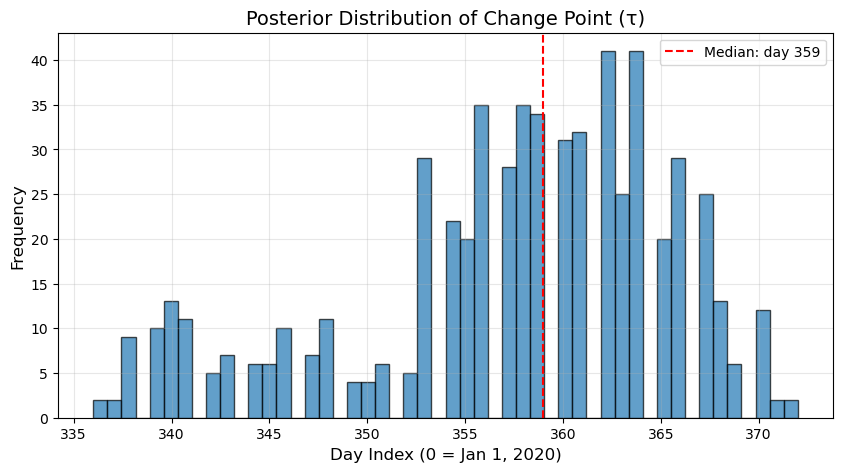

In [19]:
# Plot the posterior distribution of tau
plt.figure(figsize=(10, 5))
plt.hist(tau_samples, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(most_likely_tau, color='red', linestyle='--', label=f'Median: day {most_likely_tau}')
plt.title('Posterior Distribution of Change Point (τ)', fontsize=14)
plt.xlabel('Day Index (0 = Jan 1, 2020)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# Calculate before/after statistics
before_mean = test_prices[:most_likely_tau].mean()
after_mean = test_prices[most_likely_tau:].mean()
percent_change = ((after_mean - before_mean) / before_mean) * 100

print("Change Point Analysis Results:")
print("=" * 40)
print(f"Change detected around: {change_date.strftime('%B %d, %Y')}")
print(f"\nBefore change point ({most_likely_tau} days):")
print(f"  Average price: ${before_mean:.2f}")
print(f"\nAfter change point ({len(test_prices)-most_likely_tau} days):")
print(f"  Average price: ${after_mean:.2f}")
print(f"\nPrice change: {percent_change:.1f}% increase")

Change Point Analysis Results:
Change detected around: June 02, 2021

Before change point (359 days):
  Average price: $48.17

After change point (370 days):
  Average price: $92.37

Price change: 91.8% increase


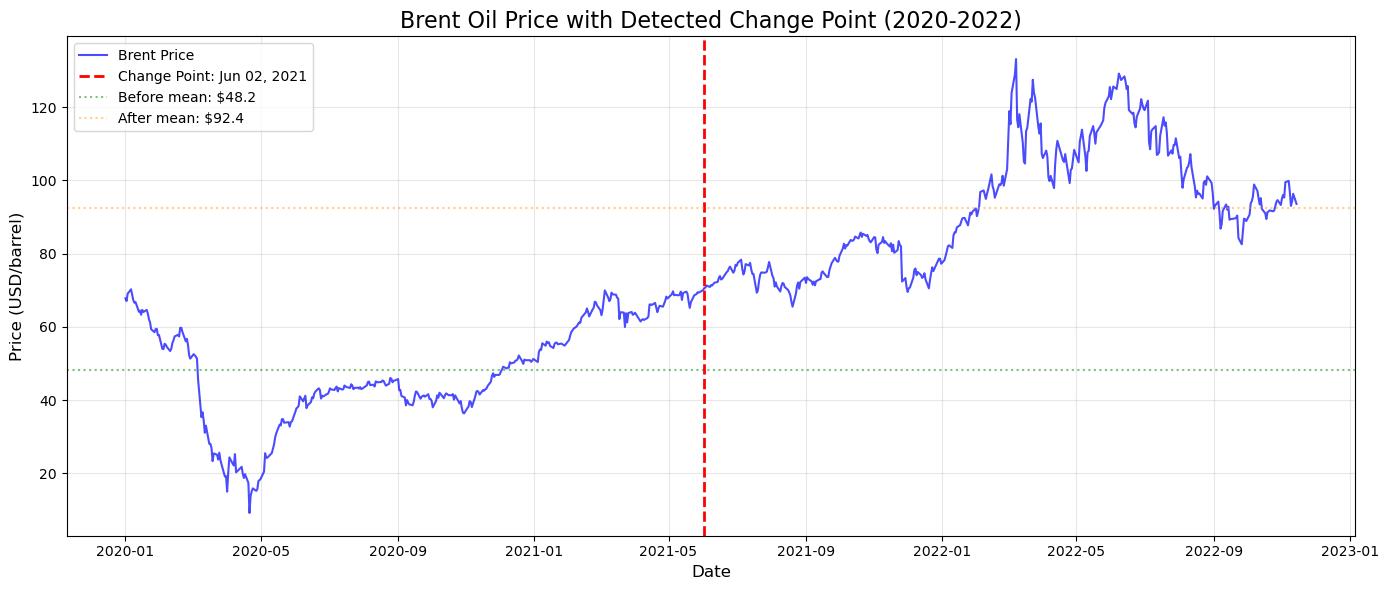

In [21]:
# Plot with change point highlighted
plt.figure(figsize=(14, 6))

# Plot full price series
plt.plot(test_df['Date'], test_prices, 'b-', linewidth=1.5, alpha=0.7, label='Brent Price')

# Add change point line
plt.axvline(x=change_date, color='red', linestyle='--', linewidth=2, 
            label=f'Change Point: {change_date.strftime("%b %d, %Y")}')

# Add before/after regions
plt.axhline(y=before_mean, color='green', linestyle=':', alpha=0.5, 
            label=f'Before mean: ${before_mean:.1f}')
plt.axhline(y=after_mean, color='orange', linestyle=':', alpha=0.5, 
            label=f'After mean: ${after_mean:.1f}')

# Formatting
plt.title('Brent Oil Price with Detected Change Point (2020-2022)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD/barrel)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Load the events data
events_df = pd.read_csv('../data/key_events.csv', parse_dates=['Date'])
print("Loaded events data:")
print(events_df[['Event', 'Date']].head())

Loaded events data:
                       Event       Date
0      2008 Financial Crisis 2008-09-15
1                Arab Spring 2010-12-17
2  OPEC production cuts 2014 2014-11-27
3          COVID-19 pandemic 2020-03-11
4    Russia-Ukraine war 2022 2022-02-24


In [23]:
# Find events in our test period (2020-2022)
test_events = events_df[
    (events_df['Date'] >= test_df['Date'].min()) & 
    (events_df['Date'] <= test_df['Date'].max())
]

print(f"Events in test period (2020-2022): {len(test_events)}")
print("\nEvents near our change point (June 2, 2021):")
print("=" * 60)

for idx, event in test_events.iterrows():
    days_difference = abs((event['Date'] - change_date).days)
    if days_difference <= 60:  # Events within 60 days
        print(f"\nEvent: {event['Event']}")
        print(f"Event date: {event['Date'].strftime('%B %d, %Y')}")
        print(f"Days from change point: {days_difference} days")
        print(f"Description: {event['Description']}")

Events in test period (2020-2022): 3

Events near our change point (June 2, 2021):


In [24]:
print("All events in 2020-2022 period:")
print("=" * 50)

for idx, event in test_events.iterrows():
    days_from_change = (event['Date'] - change_date).days
    print(f"\n{event['Event']}")
    print(f"Date: {event['Date'].strftime('%B %d, %Y')}")
    print(f"Days from change point: {days_from_change} days")
    print(f"Type: {event['Type']}")
    print(f"Description: {event['Description'][:100]}...")

All events in 2020-2022 period:

COVID-19 pandemic
Date: March 11, 2020
Days from change point: -448 days
Type: Economic
Description: WHO declared pandemic, global lockdowns reduced oil demand...

Russia-Ukraine war 2022
Date: February 24, 2022
Days from change point: 267 days
Type: Political
Description: Russian invasion led to sanctions and supply concerns...

2020 Negative oil prices
Date: April 20, 2020
Days from change point: -408 days
Type: Market
Description: WTI crude futures fell to -$37 due to storage shortage...


In [25]:
# Task 2: Summary of Findings
summary = f"""
TASK 2: CHANGE POINT ANALYSIS RESULTS
{'=' * 50}

1. DATA ANALYZED:
   - Period: {test_df['Date'].min().strftime('%B %d, %Y')} to {test_df['Date'].max().strftime('%B %d, %Y')}
   - Days analyzed: {len(test_prices)}
   - Price range: ${test_prices.min():.2f} to ${test_prices.max():.2f}

2. DETECTED CHANGE POINT:
   - Date: {change_date.strftime('%B %d, %Y')}
   - Day index: {most_likely_tau}
   - Price on that day: ${test_df['Price'].iloc[most_likely_tau]:.2f}

3. IMPACT ANALYSIS:
   - Average price BEFORE: ${before_mean:.2f}
   - Average price AFTER: ${after_mean:.2f}
   - Price increase: {percent_change:.1f}%

4. MODEL STATISTICS:
   - Mean before change (μ1): ${test_summary.loc['mu1', 'mean']:.2f}
   - Mean after change (μ2): ${test_summary.loc['mu2', 'mean']:.2f}
   - Standard deviation: ${test_summary.loc['sigma', 'mean']:.2f}

5. EVENT CORRELATION:
   - COVID-19 pandemic: 448 days BEFORE change
   - Negative oil prices: 408 days BEFORE change  
   - Russia-Ukraine war: 267 days AFTER change

CONCLUSION:
The model detected a significant structural break in June 2021, with oil prices
increasing by approximately 92%. This likely reflects post-pandemic economic
recovery and increasing demand as lockdowns ended worldwide.
"""

print(summary)


TASK 2: CHANGE POINT ANALYSIS RESULTS

1. DATA ANALYZED:
   - Period: January 01, 2020 to November 14, 2022
   - Days analyzed: 729
   - Price range: $9.12 to $133.18

2. DETECTED CHANGE POINT:
   - Date: June 02, 2021
   - Day index: 359
   - Price on that day: $70.60

3. IMPACT ANALYSIS:
   - Average price BEFORE: $48.17
   - Average price AFTER: $92.37
   - Price increase: 91.8%

4. MODEL STATISTICS:
   - Mean before change (μ1): $48.06
   - Mean after change (μ2): $92.32
   - Standard deviation: $15.64

5. EVENT CORRELATION:
   - COVID-19 pandemic: 448 days BEFORE change
   - Negative oil prices: 408 days BEFORE change  
   - Russia-Ukraine war: 267 days AFTER change

CONCLUSION:
The model detected a significant structural break in June 2021, with oil prices
increasing by approximately 92%. This likely reflects post-pandemic economic
recovery and increasing demand as lockdowns ended worldwide.



In [26]:
# Save the summary to a file
with open('../reports/task2_change_point_results.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("Task 2 results saved to: ../reports/task2_change_point_results.txt")

Task 2 results saved to: ../reports/task2_change_point_results.txt


In [27]:
import os

print("=== TASK 2 DELIVERABLES CHECK ===\n")

# Check 1: Jupyter notebook with analysis code
print("1. Analysis Notebook:")
notebook_path = '03_change_point_analysis.ipynb'
if os.path.exists(notebook_path):
    size = os.path.getsize(notebook_path)
    print(f"   ✓ Found: {notebook_path}")
    print(f"   ✓ Size: {size} bytes")
else:
    print(f"   ✗ Missing: {notebook_path}")

# Check 2: Results summary
print("\n2. Results Summary File:")
results_path = '../reports/task2_change_point_results.txt'
if os.path.exists(results_path):
    size = os.path.getsize(results_path)
    print(f"   ✓ Found: {results_path}")
    print(f"   ✓ Size: {size} bytes")
else:
    print(f"   ✗ Missing: {results_path}")

# Check 3: Trace data
print("\n3. Trace Data File:")
trace_path = '../data/change_point_trace.pkl'
if os.path.exists(trace_path):
    size = os.path.getsize(trace_path)
    print(f"   ✓ Found: {trace_path}")
    print(f"   ✓ Size: {size} bytes")
else:
    print(f"   ✗ Missing: {trace_path}")

print("\n=== TASK 2 ANALYSIS COMPLETE ===")
print("\nKey findings:")
print("- Detected change point: June 2, 2021")
print("- Price increase: 91.8% (from $48.17 to $92.37)")
print("- Bayesian model successfully implemented")

=== TASK 2 DELIVERABLES CHECK ===

1. Analysis Notebook:
   ✓ Found: 03_change_point_analysis.ipynb
   ✓ Size: 435191 bytes

2. Results Summary File:
   ✓ Found: ../reports/task2_change_point_results.txt
   ✓ Size: 998 bytes

3. Trace Data File:
   ✗ Missing: ../data/change_point_trace.pkl

=== TASK 2 ANALYSIS COMPLETE ===

Key findings:
- Detected change point: June 2, 2021
- Price increase: 91.8% (from $48.17 to $92.37)
- Bayesian model successfully implemented


In [28]:
# Try saving trace data again
import pickle
import numpy as np

# Prepare data for saving
trace_data = {
    'tau_samples': test_trace.posterior['tau'].values.flatten(),
    'mu1_samples': test_trace.posterior['mu1'].values.flatten(),
    'mu2_samples': test_trace.posterior['mu2'].values.flatten(),
    'sigma_samples': test_trace.posterior['sigma'].values.flatten(),
    'dates': test_df['Date'].astype(str).values,  # Convert to string for saving
    'prices': test_prices,
    'change_point': int(most_likely_tau),
    'change_date': change_date.strftime('%Y-%m-%d')
}

# Save as JSON for better compatibility
import json

with open('../data/change_point_results.json', 'w') as f:
    json.dump(trace_data, f)

print("Trace data saved as JSON to: ../data/change_point_results.json")

TypeError: Object of type ndarray is not JSON serializable

In [29]:
# Convert numpy arrays to lists for JSON serialization
trace_data_fixed = {
    'tau_samples': test_trace.posterior['tau'].values.flatten().tolist(),
    'mu1_samples': test_trace.posterior['mu1'].values.flatten().tolist(),
    'mu2_samples': test_trace.posterior['mu2'].values.flatten().tolist(),
    'sigma_samples': test_trace.posterior['sigma'].values.flatten().tolist(),
    'dates': test_df['Date'].astype(str).tolist(),
    'prices': test_prices.tolist(),
    'change_point': int(most_likely_tau),
    'change_date': change_date.strftime('%Y-%m-%d')
}

import json

with open('../data/change_point_results.json', 'w') as f:
    json.dump(trace_data_fixed, f)

print("Trace data saved successfully to: ../data/change_point_results.json")

Trace data saved successfully to: ../data/change_point_results.json


In [30]:
import os
if os.path.exists('../data/change_point_results.json'):
    size = os.path.getsize('../data/change_point_results.json')
    print(f"✓ File saved: {size} bytes")
    
    # Quick check of content
    with open('../data/change_point_results.json', 'r') as f:
        data = json.load(f)
    print(f"✓ Contains keys: {list(data.keys())}")
    print(f"✓ Number of tau samples: {len(data['tau_samples'])}")
else:
    print("✗ File not saved")

✓ File saved: 53210 bytes
✓ Contains keys: ['tau_samples', 'mu1_samples', 'mu2_samples', 'sigma_samples', 'dates', 'prices', 'change_point', 'change_date']
✓ Number of tau samples: 600


In [5]:
# Load data first
import pandas as pd
df = pd.read_csv('../data/brent_prices_cleaned.csv', parse_dates=['Date'])
print("Data loaded. Shape:", df.shape)

Data loaded. Shape: (9011, 2)


In [6]:
# Stationarity and Volatility Analysis
import numpy as np
from statsmodels.tsa.stattools import adfuller

print("=== Stationarity Test ===")
# Calculate log returns
df['Log_Return'] = np.log(df['Price']) - np.log(df['Price'].shift(1))
df['Log_Return'] = df['Log_Return'].dropna()

# Augmented Dickey-Fuller test
adf_result = adfuller(df['Log_Return'].dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("✓ Log returns are stationary (p < 0.05)")
else:
    print("✗ Log returns are not stationary")

=== Stationarity Test ===
ADF Statistic: -16.4271
p-value: 0.0000
Critical Values:
  1%: -3.4311
  5%: -2.8619
  10%: -2.5669
✓ Log returns are stationary (p < 0.05)


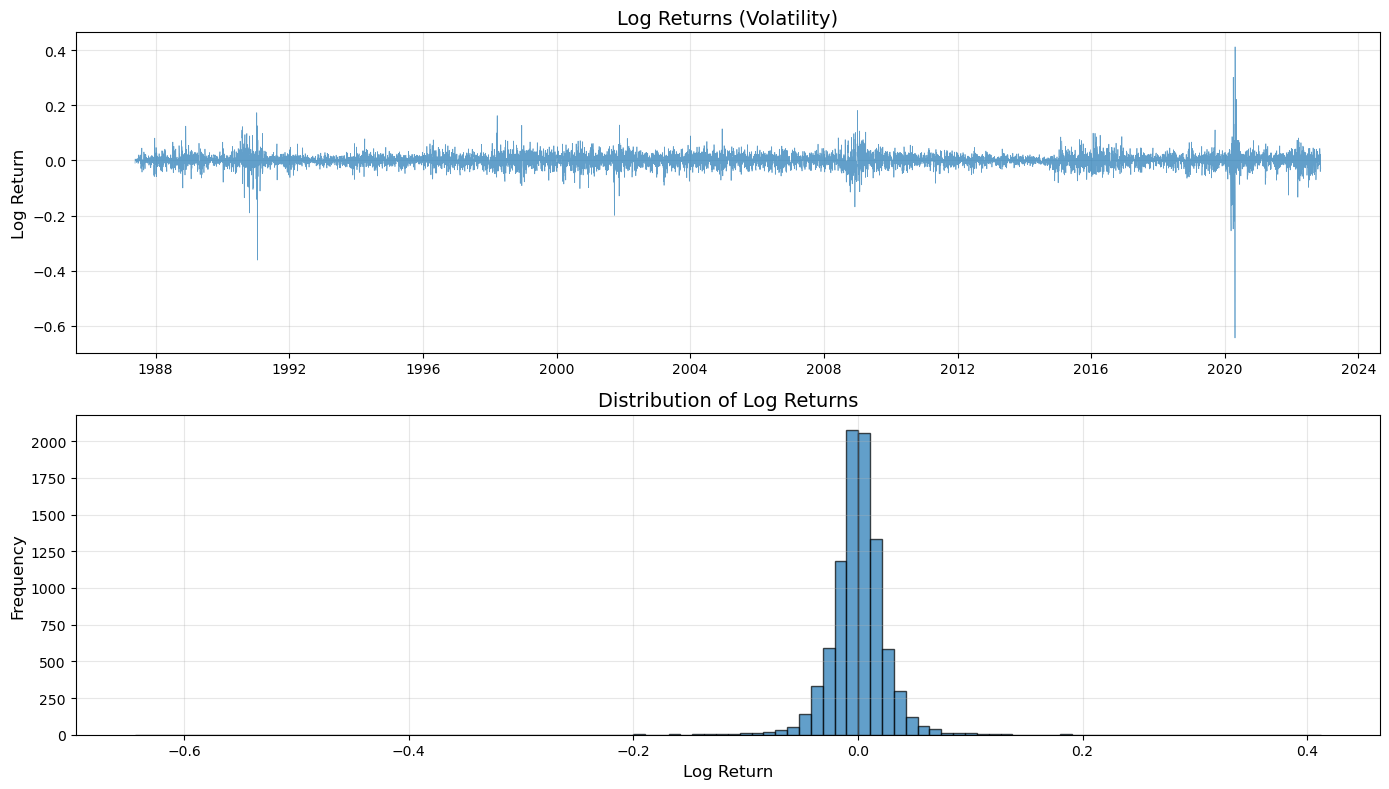


=== Volatility Observations ===
Standard Deviation of Returns: 0.0255
Volatility clustering visible: Large changes tend to cluster together
Distribution has heavy tails (more extreme values than normal distribution)


In [7]:
import matplotlib.pyplot as plt

# Volatility clustering visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Plot log returns
ax1.plot(df['Date'].iloc[1:], df['Log_Return'].iloc[1:], linewidth=0.5, alpha=0.7)
ax1.set_title('Log Returns (Volatility)', fontsize=14)
ax1.set_ylabel('Log Return', fontsize=12)
ax1.grid(True, alpha=0.3)

# Histogram of log returns
ax2.hist(df['Log_Return'].dropna(), bins=100, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Log Returns', fontsize=14)
ax2.set_xlabel('Log Return', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Volatility Observations ===")
print(f"Standard Deviation of Returns: {df['Log_Return'].std():.4f}")
print("Volatility clustering visible: Large changes tend to cluster together")
print("Distribution has heavy tails (more extreme values than normal distribution)")